In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.cm as cm

In [ ]:
# Loading data
inputFeature = pd.read_csv('../../Data/NIBRS_ND_2021/processed/input.csv', index_col='Unnamed: 0')
# Separating numerical and categorical features
numerical_features=['population','victim_seq_num','age_num_victim','incident_hour','incident_month','incident_day','incident_dayofmonth','incident_weekofyear']
categorical_features = ['resident_status_code','race_desc_victim',
'ethnicity_name_victim','pub_agency_name','offense_name','location_name','weapon_name'
,'injury_name','relationship_name','incident_isweekend']
# Onehot-encoding categorical features
inputFeature_1h = pd.get_dummies(inputFeature, columns=categorical_features)

In [3]:
# Convert object columns to numeric if they represent categories
for column in inputFeature_1h.select_dtypes(include=['object']):
    inputFeature_1h[column] = inputFeature_1h[column].astype('category').cat.codes

# Train-test split
train, test = train_test_split(inputFeature_1h, test_size=0.1, random_state=42)

# Normalizing numerical features
for feature in numerical_features:
  train[feature] = (train[feature] - train[feature].min()) / (train[feature].max() - train[feature].min())
  test[feature] = (test[feature] - test[feature].min()) / (test[feature].max() - test[feature].min())

# Converting data to tensors
X_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))
y_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))

X_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))
y_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))

In [4]:
# Dataset for tabular data
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
# Dataloaders
trainset = MyDataset(X_train, y_train)
testset = MyDataset(X_test, y_test)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

Defining a model with a 2D latent space and a mixed activation of linear and sigmoid at the output layer

In [8]:
# Model
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    # Layers
    # Encoder
    self.enc1 = nn.Linear(227, 128)
    self.bn1 = nn.BatchNorm1d(128)
    self.enc2 = nn.Linear(128, 64)
    self.bn2 = nn.BatchNorm1d(64)
    self.enc3 = nn.Linear(64, 32)
    self.bn3 = nn.BatchNorm1d(32)
    self.enc4 = nn.Linear(32, 16)
    self.bn4 = nn.BatchNorm1d(16)
    self.enc5 = nn.Linear(16, 2)
    self.bn5 = nn.BatchNorm1d(2)
      
    # Decoder
    self.dec1 = nn.Linear(2, 16)
    self.bn6 = nn.BatchNorm1d(16)
    self.dec2 = nn.Linear(16, 32)
    self.bn7 = nn.BatchNorm1d(32)
    self.dec3 = nn.Linear(32, 64)
    self.bn8 = nn.BatchNorm1d(64)
    self.dec4 = nn.Linear(64, 128)
    self.bn9 = nn.BatchNorm1d(128)
    self.dec5 = nn.Linear(128, 227)


  def encode(self, x):
    # Encoding
    x = self.bn1(F.relu(self.enc1(x)))
    x = self.bn2(F.relu(self.enc2(x)))
    x = self.bn3(F.relu(self.enc3(x)))
    x = self.bn4(F.relu(self.enc4(x)))
    enc = self.bn5(F.relu(self.enc5(x)))
    return enc

  def decode(self, enc):
    # Decoding
    x = self.bn6(F.relu(self.dec1(enc)))
    x = self.bn7(F.relu(self.dec2(x)))
    x = self.bn8(F.relu(self.dec3(x)))
    x = self.bn9(F.relu(self.dec4(x)))
    x = self.dec5(x)
    num_x = x[:, :8]
    cat_x = F.sigmoid(x[:, 8:])
    dec = torch.cat((num_x, cat_x), dim=1)
    return dec

  def forward(self, x):
    enc = self.encode(x)
    dec = self.decode(enc)
    return dec

In [9]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoEncoder().to(device)
criterion1 = nn.MSELoss()
criterion2 = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 40
print_every = 80
steps = 0
train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  running_loss_ = 0
  for X, y in trainloader:
    steps += 1
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    output = model(X)
    loss1 = criterion1(output[:, :8], y[:, :8])
    loss2 = criterion2(output[:, 8:], y[:, 8:])
    loss = loss1 + loss2
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    running_loss_ += loss.item()

    if steps % print_every == 0:
      print(f'Epoch {e+1}/{epochs}, Step {steps}, Train Loss: {running_loss_/print_every:.3f}')
      running_loss_ = 0



  else:
    running_testloss = 0
    with torch.no_grad():
      model.eval()
      for X, y in testloader:
        X, y = X.to(device), y.to(device)
        output = model(X)
        loss1 = criterion1(output[:, :8], y[:, :8])
        loss2 = criterion2(output[:, 8:], y[:, 8:])
        loss = loss1 + loss2
        running_testloss += loss.item()
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(running_testloss/len(testloader))
    print(f'Epoch {e+1}/{epochs}, Train Loss: {running_loss/len(trainloader):.3f}, Test Loss: {running_testloss/len(testloader):.3f}')

Epoch 1/40, Step 80, Train Loss: 0.874
Epoch 1/40, Step 160, Train Loss: 0.389
Epoch 1/40, Step 240, Train Loss: 0.209
Epoch 1/40, Step 320, Train Loss: 0.175
Epoch 1/40, Step 400, Train Loss: 0.168
Epoch 1/40, Step 480, Train Loss: 0.161
Epoch 1/40, Train Loss: 0.329, Test Loss: 0.161
Epoch 2/40, Step 560, Train Loss: 0.156
Epoch 2/40, Step 640, Train Loss: 0.152
Epoch 2/40, Step 720, Train Loss: 0.149
Epoch 2/40, Step 800, Train Loss: 0.146
Epoch 2/40, Step 880, Train Loss: 0.145
Epoch 2/40, Step 960, Train Loss: 0.142
Epoch 2/40, Train Loss: 0.149, Test Loss: 0.140
Epoch 3/40, Step 1040, Train Loss: 0.139
Epoch 3/40, Step 1120, Train Loss: 0.137
Epoch 3/40, Step 1200, Train Loss: 0.132
Epoch 3/40, Step 1280, Train Loss: 0.132
Epoch 3/40, Step 1360, Train Loss: 0.130
Epoch 3/40, Step 1440, Train Loss: 0.129
Epoch 3/40, Train Loss: 0.133, Test Loss: 0.126
Epoch 4/40, Step 1520, Train Loss: 0.128
Epoch 4/40, Step 1600, Train Loss: 0.127
Epoch 4/40, Step 1680, Train Loss: 0.126
Epoch 4/

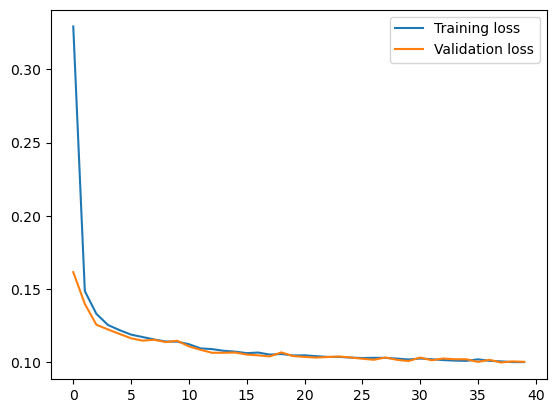

In [10]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()
plt.show()

In [11]:
with torch.no_grad():
    model.eval()
    repro = model(X_test[0:1].to(device))
    repro_ = model(X_train[0:1].to(device))

In [12]:
repro

tensor([[5.7606e-02, 2.8548e-01, 2.7562e-01, 9.2389e-01, 9.2658e-01, 2.3694e-01,
         6.8640e-01, 2.5265e-01, 2.6032e-01, 7.0921e-01, 1.9527e-03, 5.9782e-02,
         1.1313e-02, 4.6696e-01, 3.9763e-05, 9.9293e-03, 4.6482e-01, 4.3599e-02,
         8.5032e-01, 1.2790e-02, 8.7800e-02, 5.2372e-05, 6.9872e-06, 1.3908e-05,
         1.3730e-04, 1.7331e-05, 6.8511e-05, 8.1149e-06, 6.7719e-03, 3.4148e-05,
         2.8185e-05, 3.6376e-05, 1.3338e-03, 2.8333e-06, 1.0522e-05, 4.9953e-04,
         9.8427e-05, 6.6714e-04, 7.9702e-06, 2.2033e-03, 6.1475e-06, 2.4266e-06,
         1.9675e-05, 4.5228e-05, 3.1568e-05, 1.8925e-05, 1.2756e-04, 3.5486e-04,
         9.9848e-01, 8.2528e-04, 2.6229e-06, 1.1511e-04, 3.7518e-05, 2.3667e-04,
         2.4539e-03, 1.4138e-05, 1.1730e-05, 3.0817e-05, 3.4297e-05, 2.3797e-05,
         1.1942e-03, 1.1846e-04, 2.4038e-06, 6.8269e-05, 7.4509e-05, 9.1295e-05,
         4.5905e-04, 1.0683e-06, 1.8776e-03, 2.9035e-04, 1.0581e-05, 2.5453e-04,
         1.3127e-04, 2.9874e

In [13]:
X_test[0]

tensor([0.2000, 0.5000, 0.0000, 1.0000, 1.0000, 0.0909, 0.6667, 0.1154, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [14]:
all_data = pd.concat([train, test], axis=0).sort_index()
X = torch.nan_to_num(torch.Tensor(all_data.values.astype('float32')))
y = torch.nan_to_num(torch.Tensor(all_data.values.astype('float32')))
dataset = MyDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    model.eval()
    full_latent_space = []
    for X, _ in tqdm(dataloader):
        latent_space = model.encode(X.to(device))
        full_latent_space.append(latent_space)

latent_space = torch.cat(full_latent_space, dim=0)
latent_space = latent_space.to('cpu').numpy()
latent_space.shape

100%|███████████████████████████████████████████████████████████████████████████████| 534/534 [00:00<00:00, 668.66it/s]


(17058, 2)

In [15]:
ages = pd.read_csv('../Data/NIBRS_ND_2021/processed/num_out.csv', index_col='Unnamed: 0').sort_index()
ages['decade'] = ages.age_num_offender // 10
race = pd.read_csv('../Data/NIBRS_ND_2021/processed/cat_out.csv', index_col='Unnamed: 0')
race.race_desc_offender.unique()

array(['American Indian or Alaska Native', 'Black or African American',
       'White', 'Unknown', 'Asian',
       'Native Hawaiian or Other Pacific Islander'], dtype=object)

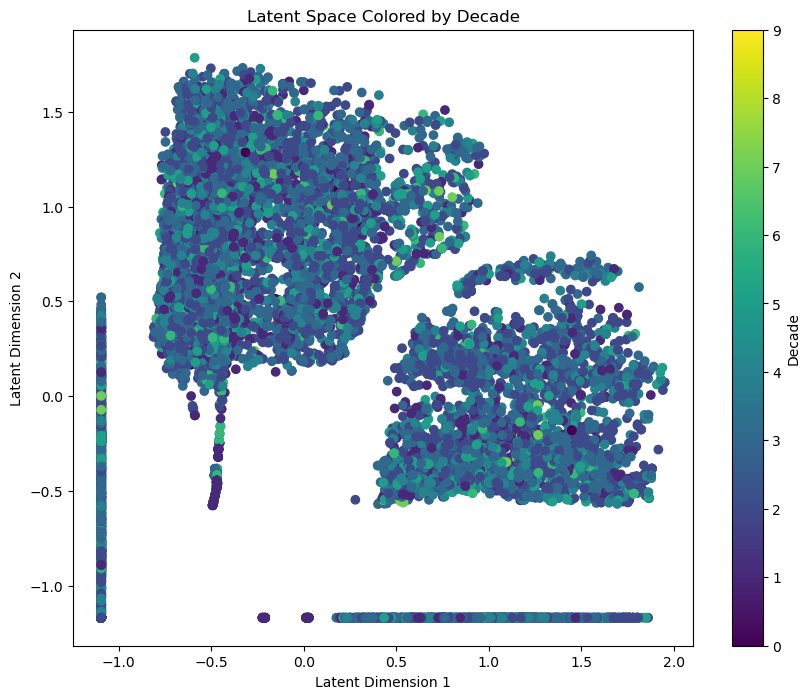

In [16]:
# Plotting the scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_space[:, 0], latent_space[:, 1], c=ages['decade'], cmap='viridis')
plt.colorbar(scatter, label='Decade')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Colored by Decade')
plt.show()

In [17]:
ages.decade.unique()

array([3, 1, 2, 4, 6, 5, 7, 0, 8, 9], dtype=int64)

In [18]:
ages.age_num_offender

6664      34
6665      34
6666      34
6667      34
6691      19
          ..
124433    34
124434    28
124435    23
124436    36
124438    29
Name: age_num_offender, Length: 17058, dtype: int64

C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_5096\2718793905.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(unique_decades))


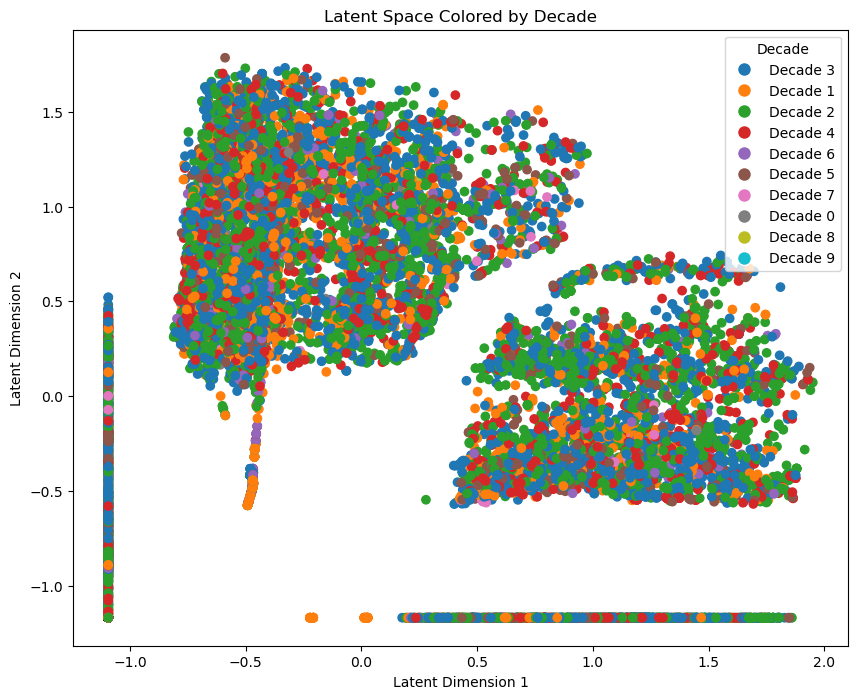

In [19]:
import matplotlib.cm as cm

# Get unique decades
unique_decades = ages['decade'].unique()

# Create a colormap for discrete categories
cmap = cm.get_cmap('tab10', len(unique_decades))

# Map each decade to an integer
decade_to_int = {decade: idx for idx, decade in enumerate(unique_decades)}
colors = ages['decade'].map(decade_to_int)

# Plotting the scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_space[:, 0], latent_space[:, 1], c=colors, cmap=cmap)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(len(unique_decades))]
labels = [f'Decade {decade}' for decade in unique_decades]
plt.legend(handles, labels, title='Decade')

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Colored by Decade')
plt.show()

C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_5096\1424750629.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(unique_races))


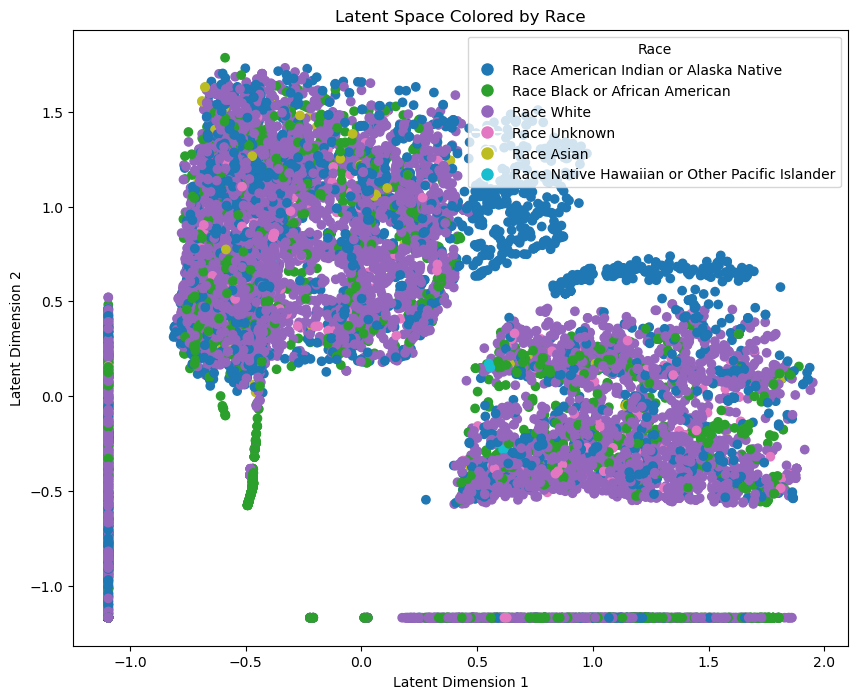

In [20]:
# Get unique decades
unique_races = race['race_desc_offender'].unique()

# Create a colormap for discrete categories
cmap = cm.get_cmap('tab10', len(unique_races))

# Map each decade to an integer
race_to_int = {race: idx for idx, race in enumerate(unique_races)}
colors = race['race_desc_offender'].map(race_to_int)

# Plotting the scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_space[:, 0], latent_space[:, 1], c=colors, cmap=cmap)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(len(unique_decades))]
labels = [f'Race {race}' for race in unique_races]
plt.legend(handles, labels, title='Race')

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Colored by Race')
plt.show()

C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_5096\328223557.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', optimal_k)


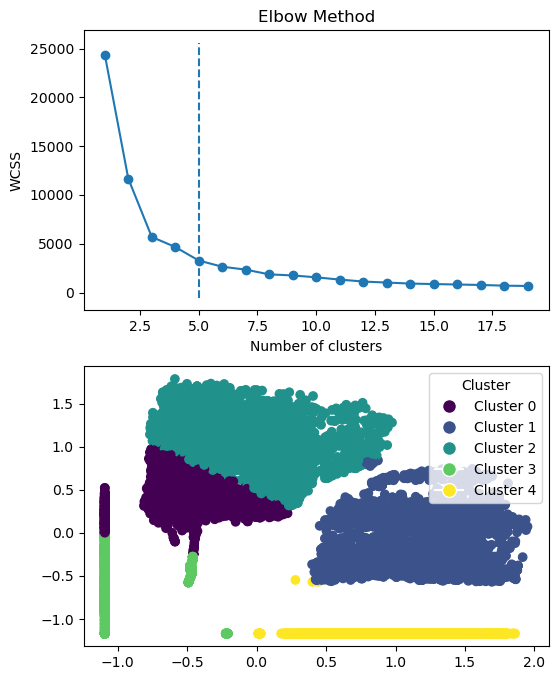

In [21]:
latent_space_2var = latent_space

# Function to calculate WCSS
def calculate_wcss(X, max_clusters):
    wcss = []
    for i in range(1, max_clusters):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    return wcss

# Calculate WCSS for different values of k
wcss = calculate_wcss(latent_space_2var, 20)

# Use KneeLocator to find the elbow point
kneedle = KneeLocator(range(1, 20), wcss, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

# Kmeans with the optimal number of clusters
kmeans_actual = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_actual.fit(latent_space_2var)

# Colormap for clustering
cmap = cm.get_cmap('viridis', optimal_k)

f, ax = plt.subplots(2, 1, figsize=(6, 8))
# Plot the Elbow Method graph
ax[0].plot(range(1, 20), wcss, marker='o')
ax[0].vlines(optimal_k, ax[0].get_ylim()[0], ax[0].get_ylim()[1], linestyles='dashed')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('WCSS')
ax[1].scatter(latent_space_2var[:, 0], latent_space_2var[:, 1], c=kmeans_actual.labels_, cmap=cmap)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(optimal_k)]
labels = [f'Cluster {cluster}' for cluster in range(optimal_k)]
ax[1].legend(handles, labels, title='Cluster')
plt.show()

In [22]:
inputFeature = inputFeature.join(ages)
inputFeature = inputFeature.join(race)
inputFeature['cluster'] = kmeans_actual.labels_

In [23]:
cat_valuecounts = {feature: [inputFeature[feature].value_counts().idxmax(), inputFeature[feature].value_counts().max()/sum(inputFeature[feature].value_counts())*100] for feature in categorical_features + ['race_desc_offender']}
pd.DataFrame(cat_valuecounts)

,resident_status_code,race_desc_victim,ethnicity_name_victim,pub_agency_name,offense_name,location_name,weapon_name,injury_name,relationship_name,incident_isweekend,race_desc_offender
0,R,White,Not Hispanic or Latino,Fargo,Simple Assault,Residence/Home,Personal Weapons,Minor Injury,Victim Was Boyfriend/Girlfriend,False,White
1,83.650657,65.881112,85.396881,31.97913,57.562434,65.101419,81.719301,80.097344,16.842909,67.786376,58.717317


In [24]:
clusters = [inputFeature.loc[inputFeature['cluster'] == cluster] for cluster in np.unique(kmeans_actual.labels_)]
clusters_cat_valuecounts = []
for cluster in clusters:
    cluster_cat_valuecounts = {feature: [cluster[feature].value_counts().idxmax(), cluster[feature].value_counts().max()/sum(cluster[feature].value_counts())*100] for feature in categorical_features + ['race_desc_offender']}
    clusters_cat_valuecounts.append(pd.DataFrame(cluster_cat_valuecounts))
clusters_cat_valuecounts[1]

,resident_status_code,race_desc_victim,ethnicity_name_victim,pub_agency_name,offense_name,location_name,weapon_name,injury_name,relationship_name,incident_isweekend,race_desc_offender
0,R,White,Not Hispanic or Latino,Grand Forks,Simple Assault,Residence/Home,Personal Weapons,Minor Injury,Victim Was Boyfriend/Girlfriend,True,White
1,83.98827,68.267629,83.398112,16.324264,56.71849,62.881732,80.338266,80.535055,17.906718,99.639089,60.410883


In [25]:
inputFeature = inputFeature.fillna('unknown')
inputFeature.loc[inputFeature['resident_status_code'].isnull()]

,victim_seq_num,age_num_victim,resident_status_code,race_desc_victim,ethnicity_name_victim,incident_hour,pub_agency_name,offense_name,location_name,weapon_name,...,incident_day,incident_isweekend,incident_month,incident_dayofmonth,incident_weekofyear,relationship_name,age_num_offender,decade,race_desc_offender,cluster


In [26]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
inputFeature_cat = inputFeature[categorical_features + ['race_desc_offender']]
inputFeature_cat = inputFeature_cat.fillna('unknown')

In [27]:
for col in inputFeature_cat.columns:
    inputFeature_cat[col] = le.fit_transform(inputFeature_cat[col])

In [28]:
inputFeature_cat

,resident_status_code,race_desc_victim,ethnicity_name_victim,pub_agency_name,offense_name,location_name,weapon_name,injury_name,relationship_name,incident_isweekend,race_desc_offender
6664,3,5,1,27,4,2,14,7,20,0,0
6665,3,5,1,27,4,2,14,7,20,0,0
6666,1,5,1,27,4,2,14,7,20,0,0
6667,1,5,1,27,4,2,14,7,20,0,0
6691,1,5,1,33,4,32,14,7,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...
124433,0,2,1,27,11,32,8,7,12,1,2
124434,1,5,2,33,9,32,10,7,5,0,4
124435,1,5,2,76,1,32,2,6,7,0,5
124436,0,5,1,27,0,23,10,6,3,0,5


Chi-square test on the catgorical features

In [29]:
from sklearn.feature_selection import chi2
chi_scores = chi2(inputFeature_cat, inputFeature['cluster'])
chi_scores

(array([2.67128017e+01, 1.10365906e+02, 8.03845995e+00, 2.89942724e+04,
        2.29688534e+02, 4.20766758e+02, 1.51823846e+02, 1.00220346e+02,
        1.24968317e+03, 1.14733842e+04, 9.55313151e+01]),
 array([2.27213634e-005, 6.08068508e-023, 9.01794734e-002, 0.00000000e+000,
        1.54043430e-048, 9.05170405e-090, 8.27683867e-032, 8.82949193e-021,
        2.69905258e-269, 0.00000000e+000, 8.78521897e-020]))

<Axes: >

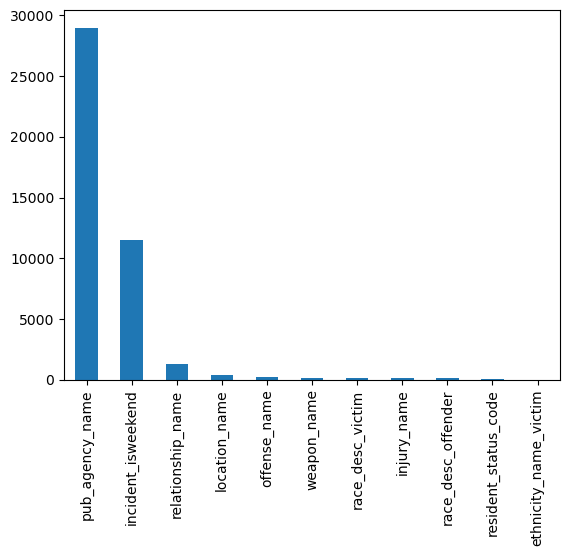

In [30]:
chi_values = pd.Series(chi_scores[0], index=inputFeature_cat.columns)
chi_values = chi_values.sort_values(ascending=False)
chi_values.plot.bar()

<Axes: >

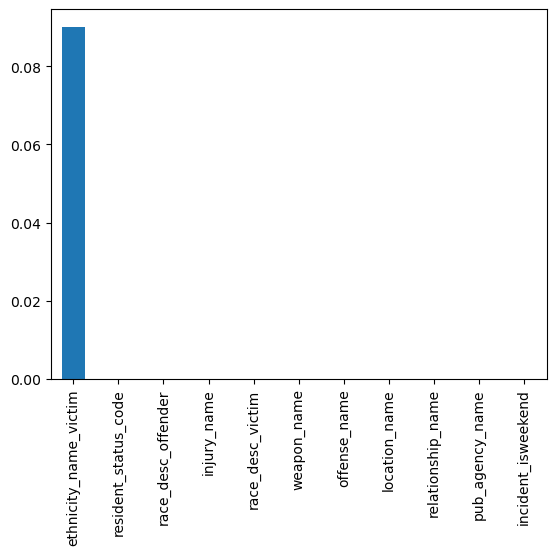

In [31]:
p_values = pd.Series(chi_scores[1], index=inputFeature_cat.columns)
p_values = p_values.sort_values(ascending=False)
p_values.plot.bar()

Comparing the variances of the numerical features in the whole dataset and within the individual clusters

In [32]:
inputFeature_num = inputFeature[numerical_features + ['age_num_offender', 'cluster']]
inputFeature_num.loc[inputFeature_num['incident_hour'] == 'unknown'] = 0
inputFeature_sigmas = inputFeature_num.drop(columns='cluster').var()
inputFeature_relative_sigmas = [pd.DataFrame({cluster: inputFeature_num.loc[inputFeature_num['cluster'] == cluster].drop(columns=['cluster']).var() / inputFeature_sigmas}) for cluster in sorted(inputFeature_num['cluster'].unique())]
z = pd.concat(inputFeature_relative_sigmas, axis=1)
z['mean'] = z.mean(axis=1)
z

,0,1,2,3,4,mean
population,0.761952,0.275668,0.2807,0.16653,0.01235,0.29944
victim_seq_num,0.699847,0.700957,0.67917,2.283564,0.666667,1.006041
age_num_victim,1.311662,0.826688,1.031447,0.858604,0.598572,0.925395
incident_hour,0.936154,1.115559,0.991483,0.846252,1.120228,1.001935
incident_month,0.952496,0.915246,0.426456,0.889559,0.863122,0.809376
incident_day,0.52078,0.058698,0.485317,0.518555,0.058654,0.328401
incident_dayofmonth,1.187032,0.913182,0.960147,0.82767,0.933124,0.964231
incident_weekofyear,0.890612,0.922547,0.633031,0.849066,0.86211,0.831473
age_num_offender,1.435087,0.749306,0.877589,0.937591,0.651015,0.930118


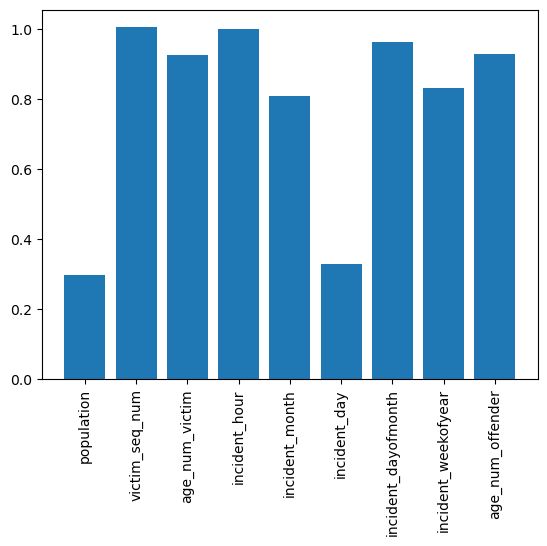

In [35]:
plt.bar(z.index, z['mean'])
plt.xticks(rotation=90)
plt.show()